1. Veri okuma

Daha önce ön işleme adımlarından geçirilen veri yüklendi.

In [2]:
import pandas as pd

file_path = "datasets/new_processed_thyroid_cancer_data.csv"
df = pd.read_csv(file_path)

df.head()  # İlk birkaç satırı görüntüle

,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,0.656629,1.400955,0.900878,0.381020,-0.645251,2.635169,-0.543565,-0.422706,-0.565731,-0.423159,1.521284,-0.393303,-0.974551,-0.998840,0.025416,0
1,-1.054325,1.400955,-0.699600,1.218197,-0.645251,2.635169,-0.543565,-0.422706,-0.565731,-0.423159,-1.128017,-0.321735,1.065424,1.089735,0.025416,0
2,1.581469,1.400955,0.500759,0.381020,-0.645251,-0.379482,-0.543565,-0.422706,-0.565731,-0.423159,0.428535,0.704061,1.079396,1.483541,0.025416,0
3,1.072807,-0.713799,-0.299480,-0.456157,-0.645251,-0.379482,-0.543565,-0.422706,-0.565731,-0.423159,-0.330416,0.739844,1.298298,-0.028391,1.380655,0
4,-0.776873,-0.713799,-0.699600,-1.293334,1.549784,2.635169,-0.543565,-0.422706,-0.565731,-0.423159,1.426415,0.131523,1.144601,-0.274519,-1.329824,0


2.2. Eğitim ve Test Veri Seti Ayrımı

Bağımsız değişkenler (X) ve bağımlı değişken (y) olarak veri ayrıldı.
Daha sonra veri eğitim ve test setlerine bölündü.

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2.3. Ölçeklendirme

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. En iyi k ve mesafe değerini bulma ve performans metrikleri

Farklı K değerleri ve mesafe metrikleri kullanarak modelin performansı ölçüldü.
Her K ve metrik için doğruluk, özgünlük, duyarlılık, kesinlik ve F1 skorları hesaplandı.

k-fold Cross Valitaion Uygulandı (K=5)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import make_scorer, recall_score, precision_score, confusion_matrix

# K değerleri (sadece tek sayılar)
k_values = [k for k in range(3, 22, 2)]
distance_metrics = ['euclidean', 'manhattan', 'minkowski']
cv_folds = 5  # 5-Katlı çapraz doğrulama

results = []

# Özgüllük (Specificity) metriğini manuel olarak tanımlıyoruz
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # Hata buradaydı, `confusion_matrix` ekledik!
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)

for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        
        # Cross-validation ile metrikleri hesapla
        accuracy_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_folds, scoring='accuracy')
        mean_accuracy = np.mean(accuracy_scores)

        recall_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_folds, scoring='recall')
        mean_recall = np.mean(recall_scores)

        precision_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_folds, scoring='precision')
        mean_precision = np.mean(precision_scores)

        f1_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_folds, scoring='f1')
        mean_f1 = np.mean(f1_scores)

        specificity_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_folds, scoring=specificity_scorer)
        mean_specificity = np.mean(specificity_scores)

        results.append((k, metric, mean_accuracy, mean_f1, mean_recall, mean_precision, mean_specificity))

# Sonuçları DataFrame olarak oluştur
results_df = pd.DataFrame(results, columns=["K", "Metric", "Mean Accuracy", "Mean F1 Score", "Mean Recall", "Mean Precision", "Mean Specificity"])

# En iyi parametreleri belirleme (F1 skoruna göre)
en_iyi_sonuc = results_df.sort_values(by="Mean F1 Score", ascending=False).iloc[0]
best_k = int(en_iyi_sonuc["K"])
best_metric = en_iyi_sonuc["Metric"]

3.2. K-Fold Cross Validation Sonrası Edinilen En İyi 10 Verinin Sıralanması

In [6]:
from IPython.display import display
display(results_df.sort_values(by="Mean F1 Score", ascending=False).head(10))

print(f"Çapraz doğrulama sonrası en iyi sonuç: K={best_k}, Mesafe Metrik={best_metric}")

,K,Metric,Mean Accuracy,Mean F1 Score,Mean Recall,Mean Precision,Mean Specificity
10,3,manhattan,0.761632,0.771262,0.803924,0.741151,0.719359
11,5,manhattan,0.763060,0.768867,0.788387,0.750295,0.737746
12,7,manhattan,0.763087,0.765987,0.775669,0.756546,0.750511
13,9,manhattan,0.762976,0.763719,0.766307,0.761151,0.759647
14,11,manhattan,0.762448,0.761706,0.759527,0.763904,0.765367
15,13,manhattan,0.762069,0.759904,0.753237,0.766694,0.770896
16,15,manhattan,0.761670,0.758365,0.748180,0.768836,0.775154
20,3,minkowski,0.749978,0.757718,0.782112,0.734801,0.717859
0,3,euclidean,0.749978,0.757718,0.782112,0.734801,0.717859
17,17,manhattan,0.761552,0.757231,0.743936,0.771014,0.779159


Çapraz doğrulama sonrası en iyi sonuç: K=3, Mesafe Metrik=manhattan


3.3. En iyi metriklerle eğitim

Seçilen en iyi K ve mesafe metriği ile modeli tekrar eğitildi.

In [7]:
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn_best.fit(X_train_scaled, y_train)
y_pred_best = knn_best.predict(X_test_scaled)

print(f"Model en iyi parametrelerle eğitildi")

Model en iyi parametrelerle eğitildi


4. Performans Metrikleri

Seçilen en iyi modelin doğruluk, duyarlılık, kesinlik, özgünlük ve F1 skorları hesaplandı.

In [8]:
# Gerekli kütüphaneleri import et
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Performans metriklerini hesapla
accuracy = accuracy_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best).ravel()
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

# Sonuçları ekrana yazdır
print(f"En İyi Modelin Performans Metrikleri:")
print(f"Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Duyarlılık (Sensitivity / Recall): {recall:.4f}")
print(f"Özgünlük (Specificity): {specificity:.4f}")
print(f"Kesinlik (Precision): {precision:.4f}")
print(f"F1 Skoru: {f1:.4f}")

En İyi Modelin Performans Metrikleri:
Doğruluk (Accuracy): 0.7708
Duyarlılık (Sensitivity / Recall): 0.8202
Özgünlük (Specificity): 0.7213
Kesinlik (Precision): 0.7467
F1 Skoru: 0.7817


4.1. ROC Eğrisi

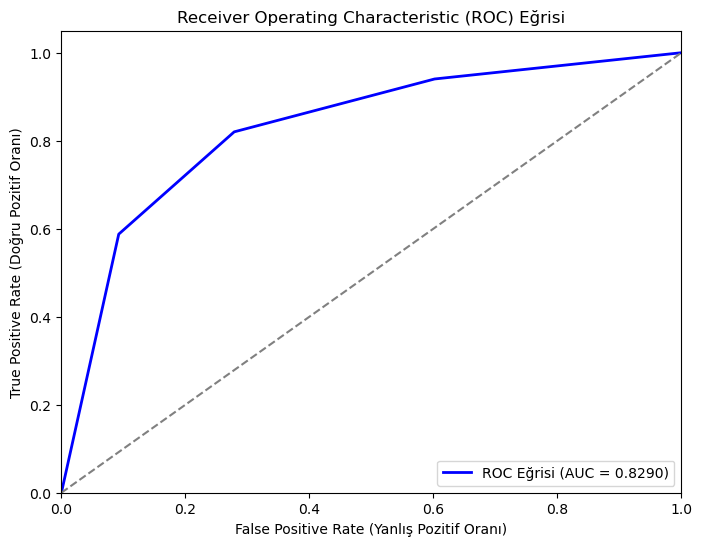

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

# Olasılık tahminlerini al
y_prob = knn_best.predict_proba(X_test_scaled)[:, 1]  # Pozitif sınıfın olasılık değerleri

# ROC Eğrisini Hesapla
fpr, tpr, _ = roc_curve(y_test.astype(int), y_prob)  # Eğer y_test float veya object ise int'e çevir
roc_auc = auc(fpr, tpr)

# ROC Eğrisini Çizdir
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Eğrisi (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Rastgele tahmin çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)')
plt.title('Receiver Operating Characteristic (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.show()

4.2. Özellik Önem Sıralaması

Random Forest modeli kullanarak özelliklerin model üzerindeki önem derecelerini belirlendi.
Model eğitildikten sonra, en önemli 10 özellik grafik ile görselleştirildi.

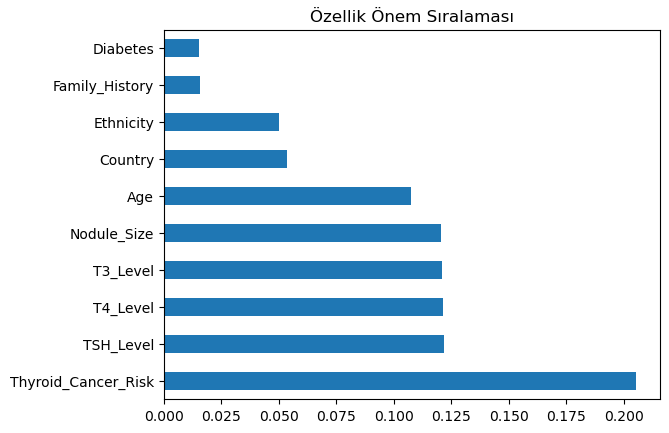

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Özellik Önem Sıralaması")
plt.show()
